# Quantum models for two-dimensional function fitting.







Reference paper from where we took the quantum model:
1. Paper: "Multidimensional Fourier series with quantum circuits"
Berta Casas and Alba Cervera-Lierta
https://journals.aps.org/pra/abstract/10.1103/PhysRevA.107.062612
2. Github Repo: https://github.com/bsc-quantic/fourier

In [ ]:
pip install plotly==5.22.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 64.9 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [ ]:
pip install nbformat>=4.2.0

In [ ]:
# Import everything we need
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

#minimization
from scipy.optimize import minimize

# Windowed quantum model.

Our contribution starts from here. We saw a very low accuracy for the case above. Now we show that we can have improvedaccuracy with windowed data/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class fitting_qubit:
    def __init__(self, layers, ansatz, qubits, test_samples=500, train_samples=1000, seed=7,
                 start_x=0, start_y=0, window_size_x=None, window_size_y=None):
        """
        Class to fit a 2D function using a quantum model with feature reuploading.
        Instead of a smooth window, we take a rectangular patch of the data.

        Args:
            layers (int): Number of layers in the circuit ansatz.
            ansatz (int): Parameterization style of the circuit.
            qubits (int): Number of qubits (here it's 1).
            test_samples (int): number of test data points in each dimension.
            train_samples (int): number of train data points in each dimension.
            seed (int): Random seed.
            start_x (int): Starting index along the x dimension for the patch.
            start_y (int): Starting index along the y dimension for the patch.
            window_size_x (int): Size of the patch along the x-axis.
            window_size_y (int): Size of the patch along the y-axis.
        """

        np.random.seed(seed)
        self.layers = layers
        self.qubits = qubits
        self.ansatz = ansatz

        # Determine number of points per dimension
        self.train_samples = int(np.sqrt(train_samples))
        self.test_samples = int(np.sqrt(test_samples))

        lins_tr = np.pi
        lins_te = np.pi + 0.0001

        x1_train = np.linspace(-lins_tr, lins_tr, self.train_samples)
        x2_train = np.linspace(-lins_tr, lins_tr, self.train_samples)
        x1_test = np.linspace(-lins_te, lins_te, self.test_samples)
        x2_test = np.linspace(-lins_te, lins_te, self.test_samples)

        self.xtrain = np.meshgrid(x1_train, x2_train)   # full training grid
        self.xtest = np.meshgrid(x1_test, x2_test)      # full test grid

        # Original target function (full grid)
        self.function_train_original = self.funct(self.xtrain[0], self.xtrain[1])
        self.function_test = self.funct(self.xtest[0], self.xtest[1])

        # If window sizes are given, extract a patch
        if window_size_x is not None and window_size_y is not None:
            end_x = start_x + window_size_x
            end_y = start_y + window_size_y

            # Check boundaries
            if start_x < 0 or start_y < 0 or end_x > self.train_samples or end_y > self.train_samples:
                raise ValueError("The specified patch does not fit within the training data range.")

            # Extract the patch from the full training data
            self.xtrain_patch = (
                self.xtrain[0][start_x:end_x, start_y:end_y],
                self.xtrain[1][start_x:end_x, start_y:end_y]
            )
            self.function_train_patch = self.function_train_original[start_x:end_x, start_y:end_y]
        else:
            # If no patch specified, train on the full data (not recommended for this demonstration)
            self.xtrain_patch = self.xtrain
            self.function_train_patch = self.function_train_original

        # Initialize parameters
        self.params = np.random.uniform(size=(self.layers+1, self.ansatz))


    def funct(self, x, y=None):
        """
        Generate the target function
        """
        g = -0.02 + 0.04*np.cos(2*x+y) + 0.25*np.sin(x) - 0.3*np.cos(2*y) - 0.1*np.sin(x - y)
        return np.real(g)

    def gates(name, param):
        """
        Implements different single-qubit gates.
        """
        j = 1j
        if name == 'Ry':
            gate = np.array([[np.cos(param/2), np.sin(param/2)],
                             [-np.sin(param/2), np.cos(param/2)]], dtype='complex')
        elif name == 'Rz':
            gate = np.array([[np.exp(j*param/2), 0],
                             [0, np.exp(-j*param/2)]], dtype='complex')
        elif name == 'Rx':
            gate = np.array([[np.cos(param/2), -j*np.sin(param/2)],
                             [-j*np.sin(param/2), np.cos(param/2)]], dtype='complex')

        return gate

    def circuit(self, x, initial_state=None):
        """Simulates the quantum circuit for a given 2D input x."""
        if initial_state is None:
            initial_state = np.array([1, 0], dtype='complex')

        params = self.params
        state = initial_state

        # zero layer. A^(0)
        state = np.dot(fitting_qubit.gates('Rz', params[0][0]), state)
        state = np.dot(fitting_qubit.gates('Ry', params[0][1]), state)
        state = np.dot(fitting_qubit.gates('Rz', params[0][2]), state)

        # l layers: S(x_1) A^(l)_1 S(x_2) A^(l)_2
        for p in params[1:]:
            # encoding
            state = np.dot(fitting_qubit.gates('Rz', x[0]), state)
            # trainable gates
            state = np.dot(fitting_qubit.gates('Rz', p[0]), state)
            state = np.dot(fitting_qubit.gates('Ry', p[1]), state)
            state = np.dot(fitting_qubit.gates('Rz', p[2]), state)

            # encoding
            state = np.dot(fitting_qubit.gates('Rz', x[1]), state)
            # trainable gates
            state = np.dot(fitting_qubit.gates('Rz', p[3]), state)
            state = np.dot(fitting_qubit.gates('Ry', p[4]), state)
            state = np.dot(fitting_qubit.gates('Rz', p[5]), state)

        expval = np.abs(state[0])**2 - np.abs(state[1])**2
        return expval

    def cost_function(self, params=None):
        """
        Cost function: compute MSE over the selected patch only.
        """
        if params is not None:
            self.params = params.reshape(self.layers+1, self.ansatz)

        loss = 0.0
        x1 = self.xtrain_patch[0]
        x2 = self.xtrain_patch[1]

        Nx, Ny = x1.shape
        # Compute MSE over the patch
        for i in range(Nx):
            for j in range(Ny):
                y_pred = self.circuit([x1[i, j], x2[i, j]])
                loss += (self.function_train_patch[i, j] - y_pred)**2

        loss /= (Nx * Ny)
        return loss

    def minimize_funct(self, method='bfgs', options=None, compile=True):
        """
        Minimization of the cost function using scipy.optimize.minimize.
        """
        m = minimize(lambda p: self.cost_function(p), x0=self.params.flatten(), method=method, options=options)
        result = m.fun
        parameters = m.x
        return result, parameters.reshape(self.layers+1, self.ansatz)



    def plot_data(self, params_opt, patch_only=False):
        """
        Plot the training data and the model's predictions using Plotly for interactive visualization.
        If patch_only=False (default), predictions over the full test grid are shown.
        If patch_only=True, predictions over only the local patch region are shown.
        """

        self.params = params_opt.reshape(self.layers+1, self.ansatz)

        if patch_only:
            # Just show predictions for the patch region
            x1_plot = self.xtrain_patch[0]
            x2_plot = self.xtrain_patch[1]
            target_plot = self.function_train_patch
            region_title = ' (Patch Only)'
        else:
            # Show predictions for the full test region
            x1_plot = self.xtest[0]
            x2_plot = self.xtest[1]
            target_plot = self.function_test
            region_title = ' (Test Grid)'

        Nx, Ny = x1_plot.shape
        f_pred = np.zeros((Nx, Ny), dtype='complex')

        SSE = 0
        SST = 0
        average = np.sum(target_plot) / target_plot.size

        for i in range(Nx):
            for j in range(Ny):
                f_pred_x = self.circuit([x1_plot[i, j], x2_plot[i, j]])
                f_pred[i, j] = f_pred_x
                SSE += (target_plot[i, j] - f_pred_x)**2
                SST += (target_plot[i, j] - average)**2

        R = 1 - SSE/SST
        print('R^2 accuracy on displayed region: ', R*100, '%')

        # -------------------------
        # 2D Contour Plots with Plotly
        # -------------------------
        fig_2d = make_subplots(rows=1, cols=3, subplot_titles=(
            'Original Training Data',
            'Training Patch (Local Region)',
            'Predicted' + region_title
        ))

        # Original Training Data contour
        fig_2d.add_trace(go.Contour(
            x=self.xtrain[0][0, :],
            y=self.xtrain[1][:, 0],
            z=self.function_train_original,
            colorscale='Viridis',
            contours=dict(showlines=False)
        ), row=1, col=1)

        # Training Patch contour
        fig_2d.add_trace(go.Contour(
            x=self.xtrain_patch[0][0, :],
            y=self.xtrain_patch[1][:, 0],
            z=self.function_train_patch,
            colorscale='Viridis',
            contours=dict(showlines=False)
        ), row=1, col=2)

        # Predicted contour on chosen region
        fig_2d.add_trace(go.Contour(
            x=x1_plot[0, :],
            y=x2_plot[:, 0],
            z=np.real(f_pred),
            colorscale='Viridis',
            contours=dict(showlines=False)
        ), row=1, col=3)

        fig_2d.update_xaxes(title_text="$x_1$", row=1, col=1)
        fig_2d.update_yaxes(title_text="$x_2$", row=1, col=1)
        fig_2d.update_xaxes(title_text="$x_1$", row=1, col=2)
        fig_2d.update_xaxes(title_text="$x_1$", row=1, col=3)

        fig_2d.update_layout(
            height=400,
            width=1000,
            title_text="2D Contour Plots",
            template="plotly_white"
        )
        fig_2d.show()

        # -------------------------
        # 3D Surface Plots with Plotly
        # -------------------------
        fig_3d = make_subplots(
            rows=1, cols=3,
            specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]],
            subplot_titles=(
                'Original Training Data',
                'Training Patch (Local Region)',
                'Predicted' + region_title
            )
        )

        # Original Training Data surface
        fig_3d.add_trace(go.Surface(
            x=self.xtrain[0],
            y=self.xtrain[1],
            z=self.function_train_original,
            colorscale='RdBu'
        ), row=1, col=1)

        # Training Patch surface
        fig_3d.add_trace(go.Surface(
            x=self.xtrain_patch[0],
            y=self.xtrain_patch[1],
            z=self.function_train_patch,
            colorscale='RdBu'
        ), row=1, col=2)

        # Predicted surface
        fig_3d.add_trace(go.Surface(
            x=x1_plot,
            y=x2_plot,
            z=np.real(f_pred),
            colorscale='RdBu'
        ), row=1, col=3)

        # Customize axes and layout
        fig_3d.update_layout(
            height=500,
            width=1200,
            title="3D Surface Plots",
            template="plotly_white",
            scene=dict(
                xaxis_title="$x_1$",
                yaxis_title="$x_2$",
                zaxis_title="Function Value"
            )
        )
        # Adjust each subplot's camera angle/view
        # For example, to rotate the view:
        # fig_3d.update_scenes(camera=dict(eye=dict(x=2, y=2, z=1)))

        fig_3d.show()

        return np.real(f_pred)



# Example usage:
layers = 2
# Define a "patch": a local region in the training data
start_x = 2
start_y = 2
window_size_x = 10
window_size_y = 10

la_model = fitting_qubit(
    layers=layers,
    ansatz=6,
    qubits=1,
    test_samples=1500,
    train_samples=500,
    start_x=start_x,
    start_y=start_y,
    window_size_x=window_size_x,
    window_size_y=window_size_y
)

# Train only on the selected patch
_, opt_params_la = la_model.minimize_funct(
    method='NELDER-MEAD',
    options={'disp': True, 'maxiter': 10000},
    compile=True
)

# Visualize the results
la_model.plot_data(opt_params_la, patch_only=True)  # Change this patch_only=True to False to measure accuracy for the whole data space not just the windowed section


Optimization terminated successfully.
         Current function value: 0.004189
         Iterations: 5329
         Function evaluations: 6870
R^2 accuracy on displayed region:  90.08973991608762 %


array([[-0.2077719 , -0.2508139 , -0.3077764 , -0.36632486, -0.40938452,
        -0.42078347, -0.39098009, -0.32087482, -0.22233749, -0.1151924 ],
       [-0.06504056, -0.1088535 , -0.16323109, -0.21507966, -0.24915362,
        -0.25310721, -0.22182979, -0.15955389, -0.07897404,  0.00236979],
       [ 0.0641598 ,  0.01665169, -0.03901598, -0.08933756, -0.12073463,
        -0.12392746, -0.09701496, -0.04620567,  0.01606047,  0.07497166],
       [ 0.15964199,  0.10218113,  0.0392265 , -0.01508591, -0.04842603,
        -0.05397312, -0.03236271,  0.00876203,  0.05741828,  0.10124275],
       [ 0.20080827,  0.12660153,  0.05160229, -0.0092233 , -0.04475363,
        -0.0506867 , -0.0303202 ,  0.00707068,  0.04965185,  0.08703987],
       [ 0.17269037,  0.07774793, -0.00976911, -0.07447822, -0.10723748,
        -0.10713671, -0.0808831 , -0.03987748,  0.0039501 ,  0.04208013],
       [ 0.07121008, -0.04302194, -0.13769784, -0.19839945, -0.21958738,
        -0.20514385, -0.16602436, -0.11592291



---



---



---



# Classical surrogation protocol applied to the quantum surrogate.
We have two independet windowes for the quantum surrogate construction and the classical surroogate construation. Quaantum surrogate can be treated as quantum model we wish to locally surrogate in this scenario.

I'm repeating the definitions from above for keeping this cell self contained in case we only want to tweak around this part.

We set the number of Fourier terms for the classical surrogate contruction at the on set with kx, ky values. We will later use a dynamic fourier term approach with the other notebook on direct classical surrogation from the target function, skiping the quantum model altogether.

Optimization terminated successfully.
         Current function value: 0.017815
         Iterations: 7696
         Function evaluations: 9918

Quantum Model Patch Evaluation:
R^2 accuracy on displayed region: 95.06%


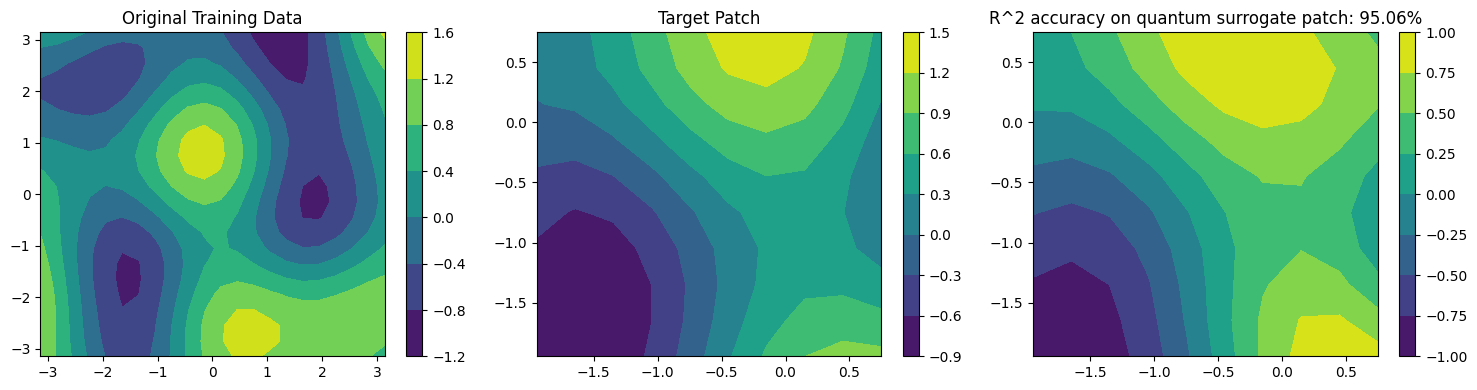


Surrogate Evaluation:

Surrogate Accuracy Metrics:
Mean Squared Error (MSE): 0.017709
R² Accuracy: 93.92%


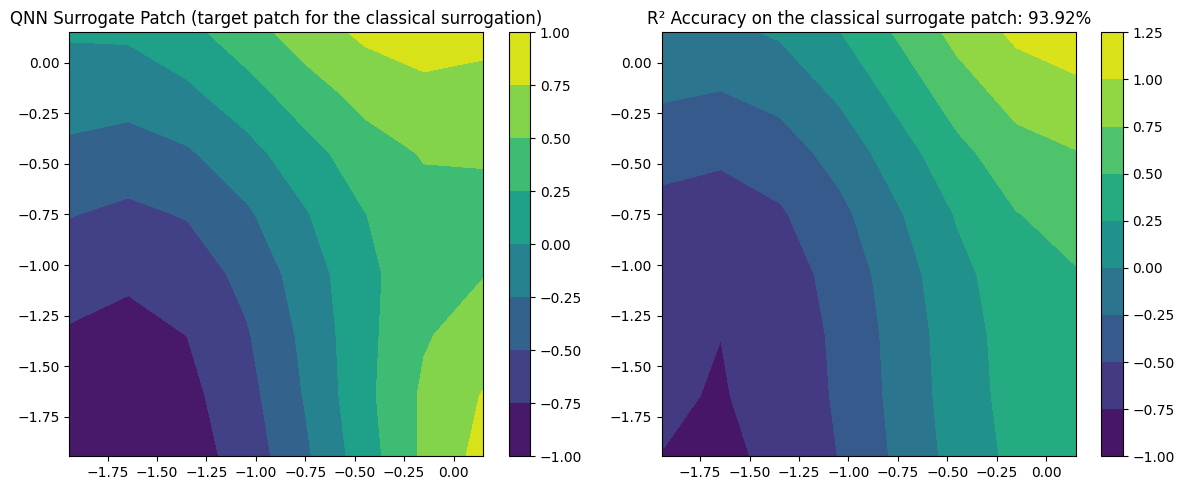

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

##########################
# 1) The Quantum Model
##########################

class FittingQubit:
    def __init__(self, layers, ansatz, qubits, test_samples=500, train_samples=1000, seed=7,
                 q_start_x=0, q_start_y=0, q_window_size_x=None, q_window_size_y=None,
                 s_start_x=0, s_start_y=0, s_window_size_x=None, s_window_size_y=None):
        """
        Class to fit a 2D function using a quantum model with feature reuploading
        and to construct a classical surrogate with independent window sizes.
        """
        np.random.seed(seed)
        self.layers = layers
        self.qubits = qubits
        self.ansatz = ansatz

        # Determine number of points per dimension
        self.train_samples = int(np.sqrt(train_samples))
        self.test_samples = int(np.sqrt(test_samples))

        lins_tr = np.pi
        lins_te = np.pi + 0.0001

        x1_train = np.linspace(-lins_tr, lins_tr, self.train_samples)
        x2_train = np.linspace(-lins_tr, lins_tr, self.train_samples)
        x1_test = np.linspace(-lins_te, lins_te, self.test_samples)
        x2_test = np.linspace(-lins_te, lins_te, self.test_samples)

        # Full training & test grids
        self.xtrain = np.meshgrid(x1_train, x2_train)   # full training grid
        self.xtest  = np.meshgrid(x1_test,  x2_test)    # full test grid

        # True function on these grids
        self.function_train_original = self.funct(self.xtrain[0], self.xtrain[1])
        self.function_test           = self.funct(self.xtest[0],  self.xtest[1])

        # Quantum model window
        if q_window_size_x is not None and q_window_size_y is not None:
            q_end_x = q_start_x + q_window_size_x
            q_end_y = q_start_y + q_window_size_y

            if q_start_x < 0 or q_start_y < 0 or q_end_x > self.train_samples or q_end_y > self.train_samples:
                raise ValueError("The quantum patch does not fit within the training data range.")

            self.xtrain_q_patch = (
                self.xtrain[0][q_start_x:q_end_x, q_start_y:q_end_y],
                self.xtrain[1][q_start_x:q_end_x, q_start_y:q_end_y]
            )
            self.function_train_q_patch = self.function_train_original[q_start_x:q_end_x, q_start_y:q_end_y]
        else:
            self.xtrain_q_patch = self.xtrain
            self.function_train_q_patch = self.function_train_original

        # Surrogate window
        if s_window_size_x is not None and s_window_size_y is not None:
            s_end_x = s_start_x + s_window_size_x
            s_end_y = s_start_y + s_window_size_y

            if s_start_x < 0 or s_start_y < 0 or s_end_x > self.train_samples or s_end_y > self.train_samples:
                raise ValueError("The surrogate patch does not fit within the training data range.")

            self.xtrain_s_patch = (
                self.xtrain[0][s_start_x:s_end_x, s_start_y:s_end_y],
                self.xtrain[1][s_start_x:s_end_x, s_start_y:s_end_y]
            )
            self.function_train_s_patch = self.function_train_original[s_start_x:s_end_x, s_start_y:s_end_y]
        else:
            self.xtrain_s_patch = self.xtrain
            self.function_train_s_patch = self.function_train_original

        # Initialize circuit parameters
        self.params = np.random.uniform(size=(self.layers+1, self.ansatz))

    def funct(self, x, y=None):
        """The 2D target function."""
        # return np.real(-0.02 + 0.04*np.cos(2*x + y) + 0.25*np.sin(x) - 0.3*np.cos(2*y) - 0.1*np.sin(x - y))
        return ( 0.05*x**2 - 0.1*y + 0.6*np.cos(1.2*x + 0.5*y) - 0.4*np.sin(0.8*x - 1.3*y) + 0.35*np.cos(2*x) + 0.2*np.sin(2*y) )  # def func_combined_oscillator(x, y): mild polynomial part

    def gates(name, param):
        """Implements different single-qubit gates (Rz, Ry, Rx)."""
        j = 1j
        if name == 'Ry':
            return np.array([[np.cos(param/2),  np.sin(param/2)],
                             [-np.sin(param/2), np.cos(param/2)]], dtype='complex')
        elif name == 'Rz':
            return np.array([[np.exp(j*param/2), 0],
                             [0, np.exp(-j*param/2)]], dtype='complex')
        elif name == 'Rx':
            return np.array([[np.cos(param/2),    -j*np.sin(param/2)],
                             [-j*np.sin(param/2), np.cos(param/2)]], dtype='complex')

    def circuit(self, x, initial_state=None):
        """Simulates the quantum circuit for a given 2D input x = [x1, x2]."""
        if initial_state is None:
            initial_state = np.array([1, 0], dtype='complex')

        params = self.params
        state = initial_state

        state = np.dot(FittingQubit.gates('Rz', params[0][0]), state)
        state = np.dot(FittingQubit.gates('Ry', params[0][1]), state)
        state = np.dot(FittingQubit.gates('Rz', params[0][2]), state)

        for p in params[1:]:
            state = np.dot(FittingQubit.gates('Rz', x[0]), state)
            state = np.dot(FittingQubit.gates('Rz', p[0]), state)
            state = np.dot(FittingQubit.gates('Ry', p[1]), state)
            state = np.dot(FittingQubit.gates('Rz', p[2]), state)

            state = np.dot(FittingQubit.gates('Rz', x[1]), state)
            state = np.dot(FittingQubit.gates('Rz', p[3]), state)
            state = np.dot(FittingQubit.gates('Ry', p[4]), state)
            state = np.dot(FittingQubit.gates('Rz', p[5]), state)

        expval = np.abs(state[0])**2 - np.abs(state[1])**2
        return expval

    def cost_function(self, params=None, for_surrogate=False):
        """MSE over the chosen patch."""
        if params is not None:
            self.params = params.reshape(self.layers+1, self.ansatz)

        x1, x2 = (self.xtrain_s_patch if for_surrogate else self.xtrain_q_patch)
        Nx, Ny = x1.shape
        function_patch = (self.function_train_s_patch if for_surrogate else self.function_train_q_patch)

        loss = 0.0
        for i in range(Nx):
            for j in range(Ny):
                y_pred = self.circuit([x1[i, j], x2[i, j]])
                loss += (function_patch[i, j] - y_pred)**2
        return loss / (Nx * Ny)

    def minimize_funct(self, method='bfgs', options=None):
        """Minimization of the cost function."""
        m = minimize(lambda p: self.cost_function(p),
                     x0=self.params.flatten(),
                     method=method, options=options)
        return m.fun, m.x.reshape(self.layers+1, self.ansatz)

    def plot_data(self, params_opt, for_surrogate=False):
        """Plot training data, model predictions, and surrogate predictions."""
        self.params = params_opt.reshape(self.layers + 1, self.ansatz)

        if for_surrogate:
            x1_plot = self.xtrain_s_patch[0]
            x2_plot = self.xtrain_s_patch[1]
            target_plot = self.function_train_s_patch
        else:
            x1_plot = self.xtrain_q_patch[0]
            x2_plot = self.xtrain_q_patch[1]
            target_plot = self.function_train_q_patch

        Nx, Ny = x1_plot.shape
        f_pred = np.zeros((Nx, Ny), dtype='complex')

        SSE = 0.0
        SST = 0.0
        avg_target = np.mean(target_plot)

        for i in range(Nx):
            for j in range(Ny):
                val_pred = self.circuit([x1_plot[i, j], x2_plot[i, j]])
                f_pred[i, j] = val_pred
                SSE += (target_plot[i, j] - val_pred) ** 2
                SST += (target_plot[i, j] - avg_target) ** 2

        R2 = 1 - SSE / SST if SST != 0 else np.nan
        print(f'R^2 accuracy on displayed region: {R2*100:.2f}%')

        # Plot 2D contour
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        im0 = axes[0].contourf(self.xtrain[0], self.xtrain[1], self.function_train_original)
        axes[0].set_title('Original Training Data')
        plt.colorbar(im0, ax=axes[0])

        im1 = axes[1].contourf(x1_plot, x2_plot, target_plot)
        axes[1].set_title('Target Patch')
        plt.colorbar(im1, ax=axes[1])

        im2 = axes[2].contourf(x1_plot, x2_plot, np.real(f_pred))
        axes[2].set_title(f'R^2 accuracy on quantum surrogate patch: {R2*100:.2f}%')
        plt.colorbar(im2, ax=axes[2])

        plt.tight_layout()
        plt.show()

        return np.real(f_pred)


##########################
# 2) Surrogation Helpers
##########################

def sample_qmodel(qmodel, x_grid, y_grid):
    """Evaluate the quantum model on a 2D grid."""
    Nx, Ny = x_grid.shape
    coords, values = [], []
    for i in range(Nx):
        for j in range(Ny):
            val_pred = qmodel.circuit([x_grid[i, j], y_grid[i, j]])
            coords.append([x_grid[i, j], y_grid[i, j]])
            values.append(val_pred)
    return np.array(coords), np.array(values)


def build_2d_fourier_matrix(coords, kx_max=3, ky_max=3):
    """Construct a Fourier design matrix."""
    N = coords.shape[0]
    n_cols = 1 + 2 * kx_max + 2 * ky_max
    A = np.zeros((N, n_cols), dtype=float)

    for i in range(N):
        x, y = coords[i]
        col_idx = 0
        A[i, col_idx] = 1.0
        col_idx += 1

        for kx in range(1, kx_max + 1):
            A[i, col_idx] = np.cos(kx * x)
            A[i, col_idx + 1] = np.sin(kx * x)
            col_idx += 2

        for ky in range(1, ky_max + 1):
            A[i, col_idx] = np.cos(ky * y)
            A[i, col_idx + 1] = np.sin(ky * y)
            col_idx += 2

    return A


def fit_2d_fourier(coords, values, kx_max=3, ky_max=3):
    """Fit a 2D Fourier surrogate."""
    A = build_2d_fourier_matrix(coords, kx_max, ky_max)
    alpha, residuals, rank, svals = np.linalg.lstsq(A, values, rcond=None)

    def surrogate_predict(x, y):
        row = np.zeros_like(alpha)
        col_idx = 0
        row[col_idx] = 1.0
        col_idx += 1

        for kx in range(1, kx_max + 1):
            row[col_idx] = np.cos(kx * x)
            row[col_idx + 1] = np.sin(kx * x)
            col_idx += 2

        for ky in range(1, ky_max + 1):
            row[col_idx] = np.cos(ky * y)
            row[col_idx + 1] = np.sin(ky * y)
            col_idx += 2

        return float(row @ alpha)

    return alpha, surrogate_predict


##########################
# Error/accuracy metric
##########################

def evaluate_surrogate_accuracy(surrogate_predict, x_patch, y_patch, qnn_values_patch):
    """
    Evaluate the accuracy of the surrogate model on a given patch.
    Args:
        surrogate_predict: Function to predict surrogate values.
        x_patch: Grid of x-values in the patch.
        y_patch: Grid of y-values in the patch.
        qnn_values_patch: Ground truth values (e.g., from the QNN).
    Returns:
        mse: Mean Squared Error of the surrogate.
        r2: R-squared accuracy metric.
    """
    Nx, Ny = x_patch.shape
    sur_preds_patch = np.array([
        surrogate_predict(x_patch[i, j], y_patch[i, j])
        for i in range(Nx) for j in range(Ny)
    ]).reshape(Nx, Ny)

    # Compute metrics
    mse = np.mean((qnn_values_patch - sur_preds_patch) ** 2)
    sst = np.sum((qnn_values_patch - np.mean(qnn_values_patch)) ** 2)
    ssr = np.sum((qnn_values_patch - sur_preds_patch) ** 2)
    r2 = 1 - (ssr / sst) if sst != 0 else np.nan

    return mse, r2, sur_preds_patch


##########################
# 3) Main Demonstration
##########################

if __name__ == "__main__":
    # Define quantum and surrogate window sizes
    q_start_x, q_start_y, q_window_size_x, q_window_size_y = 4, 4, 10, 10
    s_start_x, s_start_y, s_window_size_x, s_window_size_y = 4, 4, 8, 8

    # Train the quantum model
    layers, ansatz, qubits = 2, 6, 1
    la_model = FittingQubit(
        layers=layers, ansatz=ansatz, qubits=qubits,
        test_samples=1500, train_samples=500,
        q_start_x=q_start_x, q_start_y=q_start_y,
        q_window_size_x=q_window_size_x, q_window_size_y=q_window_size_y,
        s_start_x=s_start_x, s_start_y=s_start_y,
        s_window_size_x=s_window_size_x, s_window_size_y=s_window_size_y
    )

    _, opt_params = la_model.minimize_funct(method='NELDER-MEAD', options={'disp': True, 'maxiter': 10000})

    # Evaluate quantum patch accuracy
    print("\nQuantum Model Patch Evaluation:")
    la_model.plot_data(opt_params, for_surrogate=False)

    # Surrogate Evaluation
    print("\nSurrogate Evaluation:")
    x_s_patch = la_model.xtrain_s_patch[0]
    y_s_patch = la_model.xtrain_s_patch[1]
    coords_s_patch, qnn_values_s_patch = sample_qmodel(la_model, x_s_patch, y_s_patch)

    kx_max, ky_max = 3, 3
    alpha, surrogate_predict = fit_2d_fourier(coords_s_patch, qnn_values_s_patch, kx_max, ky_max)

    # Evaluate the surrogate
    mse, r2, sur_preds_s_patch = evaluate_surrogate_accuracy(surrogate_predict, x_s_patch, y_s_patch, qnn_values_s_patch.reshape(x_s_patch.shape))

    # Display metrics
    print(f"\nSurrogate Accuracy Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"R² Accuracy: {r2 * 100:.2f}%")

    # Plot surrogate predictions
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    im0 = axes[0].contourf(x_s_patch, y_s_patch, qnn_values_s_patch.reshape(x_s_patch.shape))
    axes[0].set_title("QNN Surrogate Patch (target patch for the classical surrogation)")
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].contourf(x_s_patch, y_s_patch, sur_preds_s_patch)
    # axes[1].set_title("Surrogate (Patch)")
    axes[1].set_title(f"R² Accuracy on the classical surrogate patch: {r2 * 100:.2f}%")
    plt.colorbar(im1, ax=axes[1])

    plt.tight_layout()
    plt.show()

# plot 1/variencs vs R2
